<h1><center>An analysis on how external factors influence football games</center></h1>

This notebook presents an exploratory data analysis to detail the impact that external factors such as crowd attendance,  the match referee or kick off time have on football games. We are going to determine if the home team has any real advantage and if they play more aggressively in comparison to the away team. In the football world there is also a myth circuling around that the surprise results tend to happen at an earlier kick off time. We intend to put this to the test. Furthermore we are going to try to determine if referees have a bias towards certain teams.

## 1. Getting the Data

In order to get the data required we looked at the following websites: 
* http://www.football-data.co.uk/
* https://www.footballcritic.com/
* https://www.worldfootball.net/

From http://www.football-data.co.uk/ we downloaded the .csv files which contain the following statistics about football teams and data around the matches that took place in the the premier league seasons 2020-2021, 2019-2020, 2018-2019.<br>The data found on this site also contains betting odds, which we are not going to look at for our current project.

|Abbreviation|Actual Name|Definition|
|:------------:|:-----------:|:----------:|
|Div|Division|League Division where the match was played|
|Date|Date|Day/Month/Year when the match was played|
|Time|Time|Time of match kick off|
|HomeTeam|Home Team|The team which is playing at home|
|AwayTeam|Away Team|The team which is playing away|
|FTHG|Full Time Home Team Goals|Goals scored after full time by the home team|
|FTAG|Full Time Away Team Goals|Goals scored after full time by the away team|
|FTR|Full Time Result|Result after full time(H=Home Win, D=Draw, A=Away Win)|
|HTHG|Half Time Home Team Goals|Goals scored after half time by the home team|
|HTAG|Half Time Away Team Goals|Goals scored after half time by the away team|
|HTR|Half Time Result|Result after half time(H=Home Win, D=Draw, A=Away Win)|
|Referee|Referee|Name of the referee|
|HS|Home Team Shots|Number of shots by the home team|
|AS|Away Team Shots|Number of shots by the away team|
|HST|Home Team Shots on Target|Number of shots on target by the home team|
|AST|Away Team Shots on Target|Number of shots on target by the away team|
|HF|Home Team Fouls Committed|Number of fouls committed by the home team|
|AF|Away Team Fouls Committed|Number of fouls committed by the away team|
|HC|Home Team Corners|Number of corners for the home team|
|AC|Away Team Corners|Number of corners for the away team|
|HY|Home Team Yellow Cards|Number of yellow cards for the home team|
|AY|Away Team Yellow Cards|Number of yellow cards for the away team|
|HR|Home Team Red Cards|Number of red cards for the home team|
|AR|Away Team Red Cards|Number of red cards for the away team|

Importing the necessart libraries and defining a function to show and hide code cells.

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%reload_ext autoreload
%autoreload 2
import random
from IPython.display import HTML
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

from urllib.request import urlopen
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import datetime
import re
from urllib.request import urlopen
from urllib.error import HTTPError
from urllib.error import URLError
import requests
import py2neo as neo


#Toggle button to hide and show code
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Show hidden code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>
        <button style ="position: relative; left: 40%;" onclick="javascript:{f_name}()">{toggle_text}</button>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

## 1.1 Checking the data

Creating dataframes for the premier league seasons 2020-2021, 2019-2020 and 2018-2019. Afterwards we removed the columns which contained betting odds, as they were not necessary to our project. Furthermore we checked each dataframe for null values and last but not least we verified that there are 380 entries in a dataframe as there are 380 games per season.

In [2]:
df_prem_2021 = pd.read_csv("data/PremierLeague/PremierLeague_2021.csv")
df_prem_1920 = pd.read_csv("data/PremierLeague/PremierLeague_1920.csv")
df_prem_1819 = pd.read_csv("data/PremierLeague/PremierLeague_1819.csv")
#We do not require the betting odds for our project so we are going to delete those columns.
#season 2020-2021
columns_to_keep = [x for x in range(df_prem_2021.shape[1]) if x not in range(24,114)]
df_prem_2021 = df_prem_2021.iloc[:, columns_to_keep]

#season 2019-2020
columns_to_keep = [x for x in range(df_prem_1920.shape[1]) if x not in range(24,114)]
df_prem_1920 = df_prem_1920.iloc[:, columns_to_keep]

#season 2018-2019
columns_to_keep = [x for x in range(df_prem_1819.shape[1]) if x not in range(23,114)]
df_prem_1819 = df_prem_1819.iloc[:, columns_to_keep]

#Hide/Show code
hide_toggle()

In [30]:
#df_prem_2021.head()
#df_prem_1920.head()
df_prem_1819.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,11,9,7,4,1,1,0,0
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,9,11,5,5,1,2,0,0
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0


In [4]:
#Checking for null values
df_prem_2021[df_prem_2021.isna().T.any()]
#df_prem_1920[df_prem_2021.isna().T.any()]
#df_prem_1819[df_prem_2021.isna().T.any()]

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR


In [5]:
#Checking if there are 380 entries, as there are 380 games in a season
df_prem_2021.info()
#df_prem_1920.info()
#df_prem_1819.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Div       380 non-null    object
 1   Date      380 non-null    object
 2   Time      380 non-null    object
 3   HomeTeam  380 non-null    object
 4   AwayTeam  380 non-null    object
 5   FTHG      380 non-null    int64 
 6   FTAG      380 non-null    int64 
 7   FTR       380 non-null    object
 8   HTHG      380 non-null    int64 
 9   HTAG      380 non-null    int64 
 10  HTR       380 non-null    object
 11  Referee   380 non-null    object
 12  HS        380 non-null    int64 
 13  AS        380 non-null    int64 
 14  HST       380 non-null    int64 
 15  AST       380 non-null    int64 
 16  HF        380 non-null    int64 
 17  AF        380 non-null    int64 
 18  HC        380 non-null    int64 
 19  AC        380 non-null    int64 
 20  HY        380 non-null    int64 
 21  AY        380 no

## 2. Saving the data

In [6]:
db=neo.Graph("neo4j+s://52d54f1d.databases.neo4j.io",
    auth=("neo4j","cUQmozgEst1IHWWMmbpPgPiRExkAYWk-qSZdKYcALwA"))

teams_20_21=[]
teams_19_20=[]
teams_18_19=[]


Data_20_21=[]
Data_19_20=[]
Data_18_19=[]


node_matcher = neo.NodeMatcher(db)
nodes_stadium=node_matcher.match("stadium")
nodes_stadium=list(nodes_stadium)

#year has to be format 20/21
def get_new_data(data,teams, year):
    for node in nodes_stadium:
        if node[year+"-sum/average"] is not None:
            data.append(int(node[year+"-sum/average"].split("/")[1].replace('.','')))
            teams.append(node["name"])


#Hide/Show code
hide_toggle()

In [7]:
get_new_data(Data_20_21, teams_20_21, "20/21")
get_new_data(Data_19_20, teams_19_20, "19/20")
get_new_data(Data_18_19, teams_18_19, "18/19")

#Hide/Show code
hide_toggle()

In [8]:
#########

## 3. Analysing the data

## 1. Chapter: Referees

We have all heard football fans shouting out profanities after their favourite team lost a game due to some controversial decisions made by the referee. In this chapter we are going to try to deduce if referees really have a bias towards certain teams.
<br>
After analysing the data we found out that there were: 
* 20 referees officiating in the premier league season 2020-2021
* 22 referees officiating in the premier league season 2019-2020
* 18 referees officiating in the premier league season 2018-2019
<br>

In 2020-2021 the highest numbers of games managed by the same referee were: 28, 28 and 26.<br>
In 2019-2020 the highest numbers of games managed by the same referee were: 32, 32 and 32.<br>
In 2018-2019 the highest numbers of games managed by the same referee were: 32, 30 and 29.<br>
The following piecharts shows the percentages how many games each referee officiated in the 3 seasons that we are looking at.
<br><br><br>

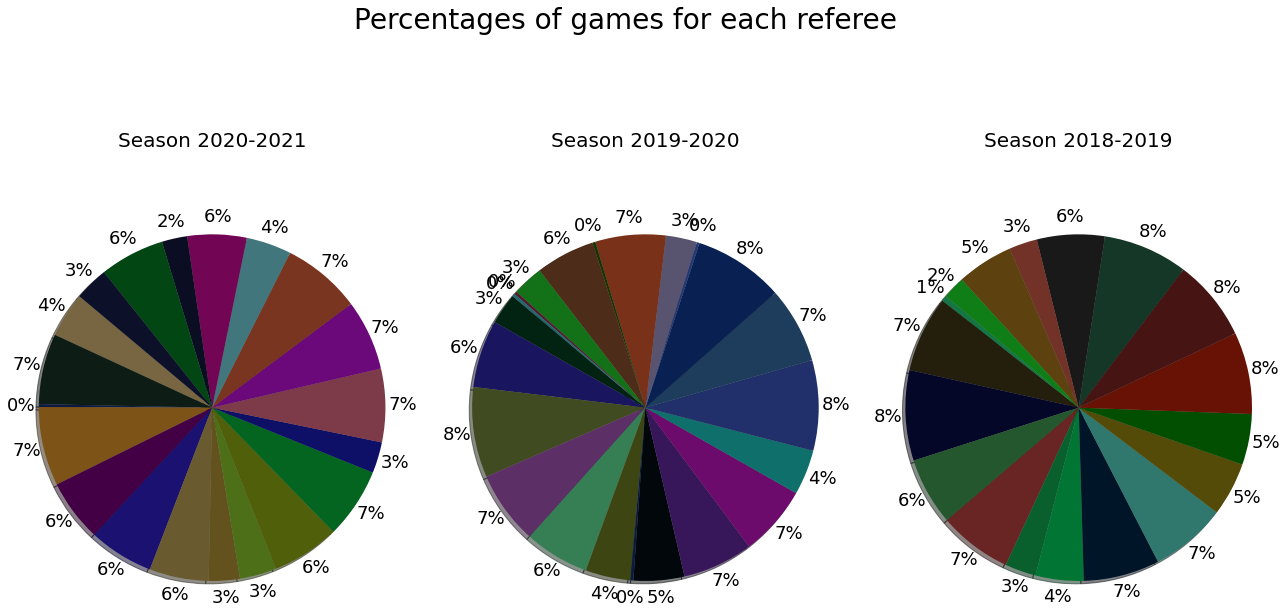

In [9]:
#20 referees in this season
num_ref_2021 = df_prem_2021['Referee'].unique().size
#22 referees in this season
num_ref_1920 = df_prem_1920['Referee'].unique().size
#18 referees in this season
num_ref_1819 = df_prem_1819['Referee'].unique().size

#Number of games for each ref in 2021
num_games_ref_2021 = df_prem_2021['Referee'].value_counts()
#Number of games for each ref in 1920
num_games_ref_1920 = df_prem_1920['Referee'].value_counts()
#Number of games for each ref in 1819
num_games_ref_1819 = df_prem_1819['Referee'].value_counts()

#the number of games for each ref--just the values
num_games_ref_2021_val = num_games_ref_2021.values
num_games_ref_1920_val = num_games_ref_1920.values
num_games_ref_1819_val = num_games_ref_1819.values


#####################PIE CHARTS#########################

names1 = df_prem_2021['Referee'].unique()
names1 = sorted(names1)
gamesRefed1 = df_prem_2021['Referee'].value_counts().sort_index(ascending=True).values

names2 = df_prem_1920['Referee'].unique()
names2 = sorted(names2)
gamesRefed2 = df_prem_1920['Referee'].value_counts().sort_index(ascending=True).values

names3 = df_prem_1819['Referee'].unique()
names3 = sorted(names3)
gamesRefed3 = df_prem_1819['Referee'].value_counts().sort_index(ascending=True).values

#fig_1 = plt.figure(figsize=(8,5),dpi=100)
#axes_1 = fig_1.add_axes([0.1,0.1,0.9,0.9])
fig, (axes_1, axes_2, axes_3) = plt.subplots(1,3)
fig.set_figheight(14)
fig.set_figwidth(22)
fig.subplots_adjust(wspace=0.2)
fig.suptitle('Percentages of games for each referee', fontsize=28, y= 0.9)
axes_1.set_title('Season 2020-2021',fontsize=20, pad=80)
axes_2.set_title('Season 2019-2020',fontsize=20, pad=80)
axes_3.set_title('Season 2018-2019',fontsize=20, pad=80)

colors1 = []
for i in range(20):
    rgb = (random.uniform(0, .5), random.uniform(0, .5), random.uniform(0, .5))
    colors1.append(rgb)
    
colors2 = []
for i in range(22):
    rgb = (random.uniform(0, .5), random.uniform(0, .5), random.uniform(0, .5))
    colors2.append(rgb)
    
colors3 = []
for i in range(18):
    rgb = (random.uniform(0, .5), random.uniform(0, .5), random.uniform(0, .5))
    colors3.append(rgb)

axes_1.pie(gamesRefed1, colors=colors1, radius = 1.2,
                                  autopct='%1.0f%%', pctdistance=1.1, shadow=True, startangle=140, 
                                  textprops=dict(color="black",fontsize=18))
axes_2.pie(gamesRefed2, colors=colors2, radius = 1.2,
                                   autopct='%1.0f%%', pctdistance=1.1, shadow=True, startangle=140, 
                                   textprops=dict(color="black",fontsize=18))
axes_3.pie(gamesRefed3, colors=colors3, radius = 1.2,
                                   autopct='%1.0f%%', pctdistance=1.1, shadow=True, startangle=140, 
                                   textprops=dict(color="black",fontsize=18))

#toggle the code
hide_toggle()

<br><br><br>
As you can see the Football Association pays great attention to the number of games that referees officiate. 
Next up, we are going to look if there are referees who are present at matches where certain teams play more than others and who these referees are.
<br><br><br><br><br><br><br><br><br>

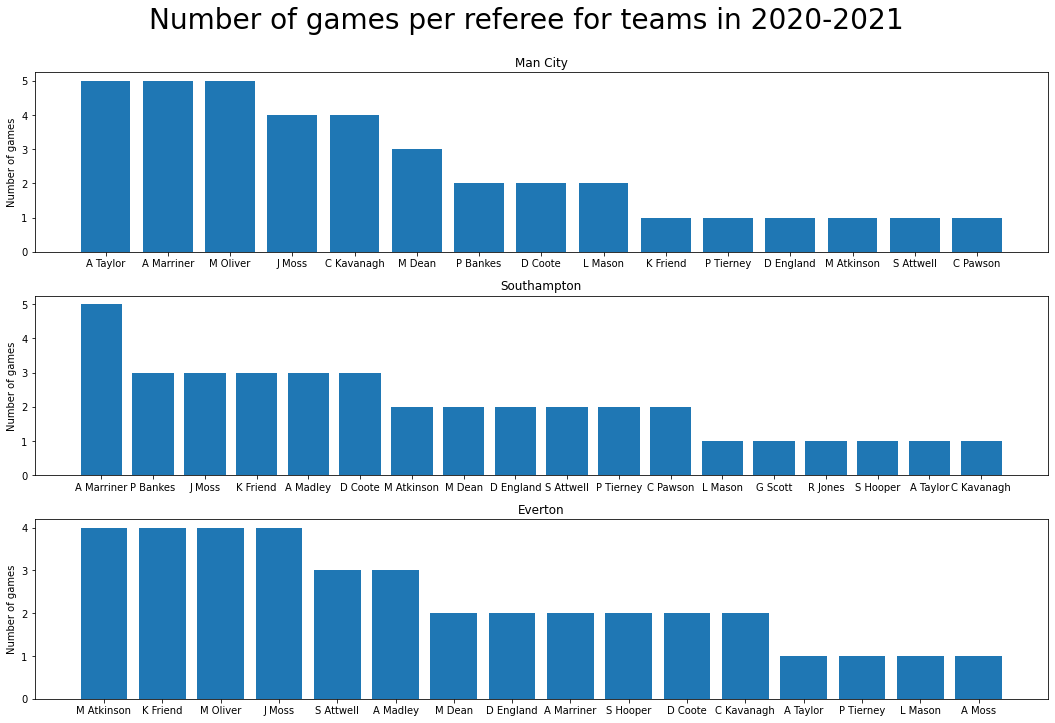

In [10]:
#Getting the number of games per ref for each team
#Dict_2021={}
#teams_2021 = sorted(df_prem_2021['HomeTeam'].unique())
#for team in teams_2021:
#    number = df_prem_2021[(df_prem_2021["HomeTeam"]==team) | (df_prem_2021["AwayTeam"]==team)]['Referee'].value_counts().values
#    Dict_2021[team] = number
#for item in Dict_2021.items():
#    print(item)

#Storing the name and number of games if a tuple for each team
Dict_2021={}
teams_2021 = sorted(df_prem_2021['HomeTeam'].unique())
for team in teams_2021:
    number = df_prem_2021[(df_prem_2021["HomeTeam"]==team) | (df_prem_2021["AwayTeam"]==team)]['Referee'].value_counts().values
    names = df_prem_2021[(df_prem_2021["HomeTeam"]==team) | (df_prem_2021["AwayTeam"]==team)]['Referee'].value_counts().index
    Dict_2021[team] = (number,names)
#for item in Dict_2021.items():
#    print(item)

fig_1, axes = plt.subplots(figsize=(15,10),nrows=3,ncols=1)
fig_1.suptitle('Number of games per referee for teams in 2020-2021', fontsize=28, y= 1.0)
axes[0].set_title('Man City')
axes[0].set_ylabel('Number of games')
axes[1].set_title('Southampton')
axes[1].set_ylabel('Number of games')
axes[2].set_title('Everton')
axes[2].set_ylabel('Number of games')
plt.tight_layout()

data0 = Dict_2021['Man City']
data1 = Dict_2021['Southampton']
data2 = Dict_2021['Everton']
axes[0].bar(data0[1],data0[0])
axes[1].bar(data1[1],data1[0])
axes[2].bar(data2[1],data2[0])

hide_toggle()

<br><br><br>We notice on our graphs that the  Football Association payed very much attention in the Premier League season 2020-2021 to how many games with the same team one referee can take part of. After looking at all the teams, we have selected 3 of them were the result, although from a very small sample size seem to indicate that these teams seem to perform better when that one referee is around. We are going to exclude Man City because they won the league, so we expected them to have a good win/lose ration.<br>
Southampton on the other hand finished in 15th place, but thanks to A Marriner got 3 wins, 1 draw and 1 loss in 5 games.
<br>
Everton also managed to secure 3 wins and 1 draw from 4 games while M Atkinson blew the whistle. They finished in 10th place.<br><br><br>

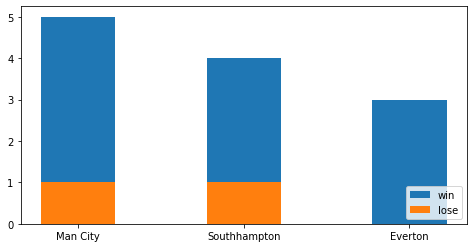

In [11]:
#Dictionaries containing the name of the team as key and the name of referee and the number of games 
#that was present most games as value as a tuple
Dict_2021={}
teams_2021 = sorted(df_prem_2021['HomeTeam'].unique())
for team in teams_2021:
    name = df_prem_2021[(df_prem_2021["HomeTeam"]==team) | (df_prem_2021["AwayTeam"]==team)]['Referee'].value_counts().index[0]
    number = df_prem_2021[(df_prem_2021["HomeTeam"]==team) | (df_prem_2021["AwayTeam"]==team)]['Referee'].value_counts().values[0]
    Dict_2021[team] = (name, number)
#for item in Dict_2021.items():
#    print(item)

    
Dict_2021_WLDRatios={}    
for key in Dict_2021:
    winhome = len(df_prem_2021[(df_prem_2021["HomeTeam"]==key) & (df_prem_2021["Referee"]==Dict_2021[key][0]) & (df_prem_2021["FTR"]=='H')].index)
    winaway = len(df_prem_2021[(df_prem_2021["AwayTeam"]==key) & (df_prem_2021["Referee"]==Dict_2021[key][0]) & (df_prem_2021["FTR"]=='A')].index)
    win = winhome + winaway
    losehome = len(df_prem_2021[(df_prem_2021["HomeTeam"]==key) & (df_prem_2021["Referee"]==Dict_2021[key][0]) & (df_prem_2021["FTR"]=='A')].index)
    loseaway = len(df_prem_2021[(df_prem_2021["AwayTeam"]==key) & (df_prem_2021["Referee"]==Dict_2021[key][0]) & (df_prem_2021["FTR"]=='H')].index)
    lose = losehome + loseaway
    drawhome = len(df_prem_2021[(df_prem_2021["HomeTeam"]==key) & (df_prem_2021["Referee"]==Dict_2021[key][0]) & (df_prem_2021["FTR"]=='D')].index)
    drawaway = len(df_prem_2021[(df_prem_2021["AwayTeam"]==key) & (df_prem_2021["Referee"]==Dict_2021[key][0]) & (df_prem_2021["FTR"]=='D')].index)
    draw = drawhome + drawaway
    Dict_2021_WLDRatios[key] = [win,lose,draw]
    
#for item in Dict_2021_WLDRatios.items():
#    print(item)

t_type = ['Man City', 'Southhampton','Everton']
w = [4,3,3]
l = [1,1,0]

ind = [x for x, _ in enumerate(t_type)]
plt.figure(figsize=(8,4))
plt.xticks(range(0,3),t_type)
plt.bar(ind, w, width=0.45, label='win',bottom=l)
plt.bar(ind, l, width=0.45, label='lose')

plt.legend(loc='lower right')

hide_toggle()

<br><br><br><br><br><br><br><br><br>

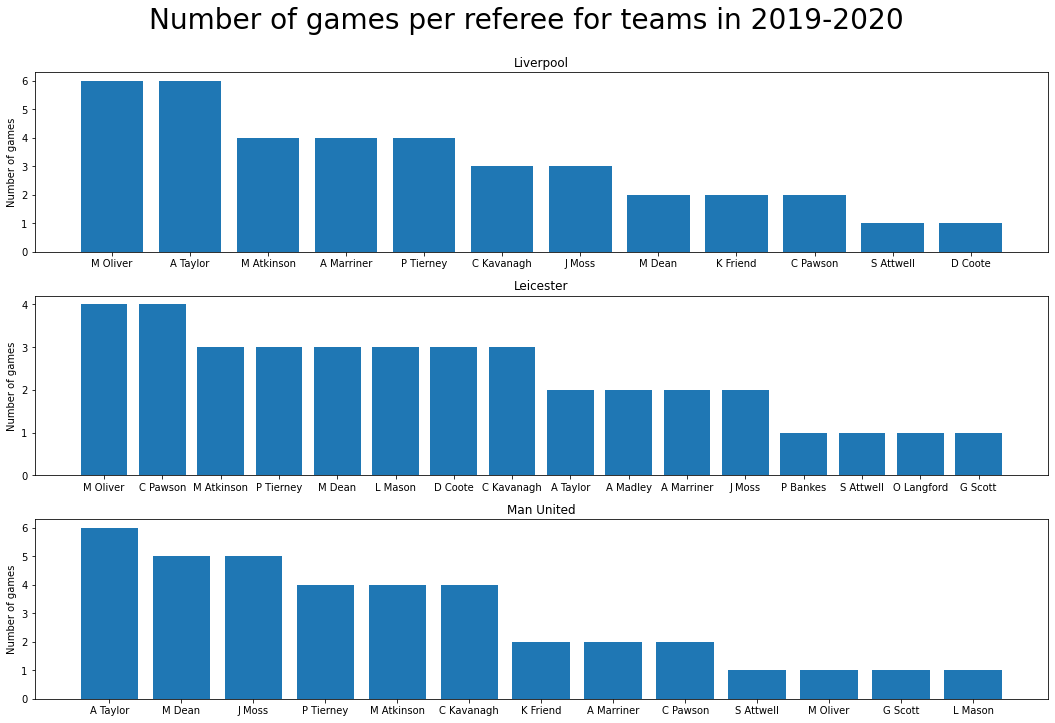

In [12]:
#Dict_1920={}
#teams_1920 = sorted(df_prem_1920['HomeTeam'].unique())
#for team in teams_1920:
#    number = df_prem_1920[(df_prem_1920["HomeTeam"]==team) | (df_prem_1920["AwayTeam"]==team)]['Referee'].value_counts().values
#    Dict_1920[team] = number
#for item in Dict_1920.items():
#    print(item)

Dict_1920={}
teams_1920 = sorted(df_prem_1920['HomeTeam'].unique())
for team in teams_1920:
    number = df_prem_1920[(df_prem_1920["HomeTeam"]==team) | (df_prem_1920["AwayTeam"]==team)]['Referee'].value_counts().values
    names = df_prem_1920[(df_prem_1920["HomeTeam"]==team) | (df_prem_1920["AwayTeam"]==team)]['Referee'].value_counts().index
    Dict_1920[team] = (number,names)
#for item in Dict_1920.items():
#    print(item)
fig_1, axes = plt.subplots(figsize=(15,10),nrows=3,ncols=1)
fig_1.suptitle('Number of games per referee for teams in 2019-2020', fontsize=28, y= 1.0)
axes[0].set_title('Liverpool')
axes[0].set_ylabel('Number of games')
axes[1].set_title('Leicester')
axes[1].set_ylabel('Number of games')
axes[2].set_title('Man United')
axes[2].set_ylabel('Number of games')
plt.tight_layout()

data0 = Dict_1920['Liverpool']
data1 = Dict_1920['Leicester']
data2 = Dict_1920['Man United']
axes[0].bar(data0[1],data0[0])
axes[1].bar(data1[1],data1[0])
axes[2].bar(data2[1],data2[0])

hide_toggle()

<br><br><br>At first glance it would seem that we have some very good candidates in the Premier League Season 2019-2020 in Liverpool and Man United. M Oliver granted 5 wins and 1 loss in 6 games, but this should not come as a surprise as Liverpool were crowned champions in that season. Man United with the same record under A Taylor face a similar situation as they finished third that year, so it was to be expected that they string together a couple of good performances.<br><br><br>

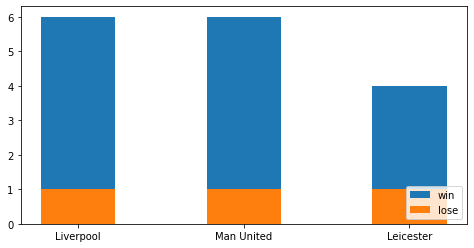

In [13]:
#Dictionaries containing the name of the team as key and the name of referee and the number of games 
#that was present most games as value as a tuple
Dict_1920={}
teams_1920 = sorted(df_prem_1920['HomeTeam'].unique())
for team in teams_1920:
    name = df_prem_1920[(df_prem_1920["HomeTeam"]==team) | (df_prem_1920["AwayTeam"]==team)]['Referee'].value_counts().index[0]
    number = df_prem_1920[(df_prem_1920["HomeTeam"]==team) | (df_prem_1920["AwayTeam"]==team)]['Referee'].value_counts().values[0]
    Dict_1920[team] = (name, number)
#for item in Dict_2021.items():
#    print(item)

    
Dict_1920_WLDRatios={}    
for key in Dict_1920:
    winhome = len(df_prem_1920[(df_prem_1920["HomeTeam"]==key) & (df_prem_1920["Referee"]==Dict_1920[key][0]) & (df_prem_1920["FTR"]=='H')].index)
    winaway = len(df_prem_1920[(df_prem_1920["AwayTeam"]==key) & (df_prem_1920["Referee"]==Dict_1920[key][0]) & (df_prem_1920["FTR"]=='A')].index)
    win = winhome + winaway
    losehome = len(df_prem_1920[(df_prem_1920["HomeTeam"]==key) & (df_prem_1920["Referee"]==Dict_1920[key][0]) & (df_prem_1920["FTR"]=='A')].index)
    loseaway = len(df_prem_1920[(df_prem_1920["AwayTeam"]==key) & (df_prem_1920["Referee"]==Dict_1920[key][0]) & (df_prem_1920["FTR"]=='H')].index)
    lose = losehome + loseaway
    drawhome = len(df_prem_1920[(df_prem_2021["HomeTeam"]==key) & (df_prem_1920["Referee"]==Dict_1920[key][0]) & (df_prem_1920["FTR"]=='D')].index)
    drawaway = len(df_prem_1920[(df_prem_2021["AwayTeam"]==key) & (df_prem_1920["Referee"]==Dict_1920[key][0]) & (df_prem_1920["FTR"]=='D')].index)
    draw = drawhome + drawaway
    Dict_1920_WLDRatios[key] = [win,lose,draw]
    
#for item in Dict_1920_WLDRatios.items():
#    print(item)

t_type = ['Liverpool', 'Man United','Leicester']
w = [5,5,3]
l = [1,1,1]

ind = [x for x, _ in enumerate(t_type)]
plt.figure(figsize=(8,4))
plt.xticks(range(0,3),t_type)
plt.bar(ind, w, width=0.45, label='win',bottom=l)
plt.bar(ind, l, width=0.45, label='lose')

plt.legend(loc='lower right')
hide_toggle()

<br><br><br><br><br><br><br><br><br>

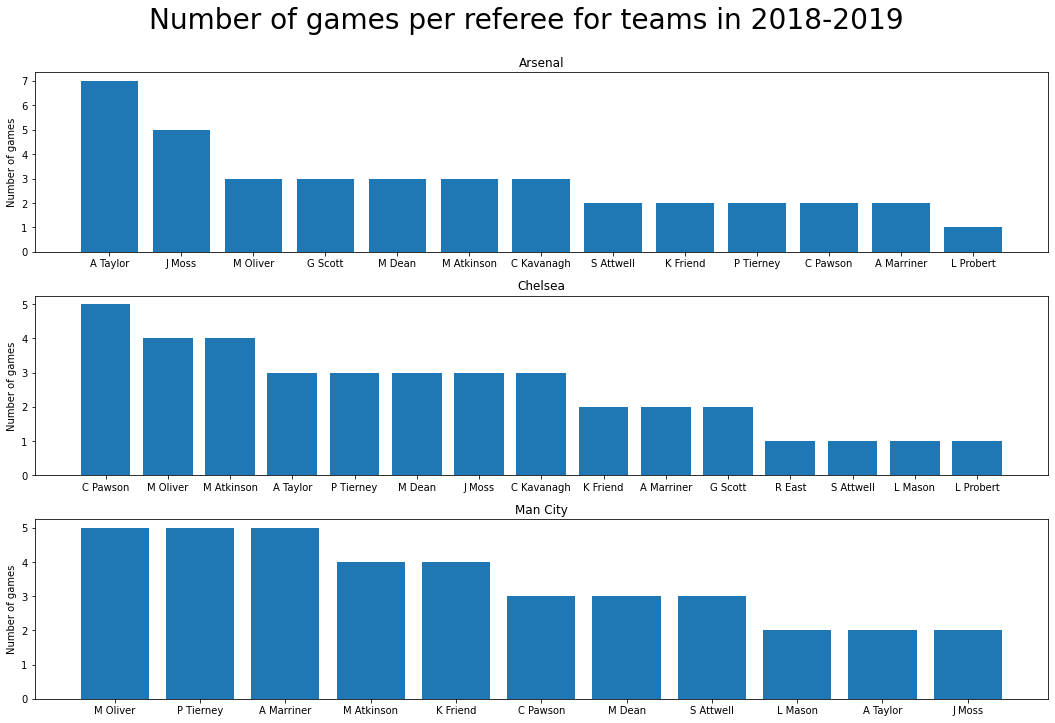

In [14]:
#Dict_1819={}
#teams_1819 = sorted(df_prem_1819['HomeTeam'].unique())
#for team in teams_1819:
#    number = df_prem_1819[(df_prem_1819["HomeTeam"]==team) | (df_prem_1819["AwayTeam"]==team)]['Referee'].value_counts().values
#    Dict_1819[team] = number
#for item in Dict_1819.items():
#    print(item)

Dict_1819={}
teams_1819 = sorted(df_prem_1819['HomeTeam'].unique())
for team in teams_1819:
    number = df_prem_1819[(df_prem_1819["HomeTeam"]==team) | (df_prem_1819["AwayTeam"]==team)]['Referee'].value_counts().values
    names = df_prem_1819[(df_prem_1819["HomeTeam"]==team) | (df_prem_1819["AwayTeam"]==team)]['Referee'].value_counts().index
    Dict_1819[team] = (number,names)
#for item in Dict_1819.items():
#    print(item)
fig_1, axes = plt.subplots(figsize=(15,10),nrows=3,ncols=1)
fig_1.suptitle('Number of games per referee for teams in 2018-2019', fontsize=28, y= 1.0)
axes[0].set_title('Arsenal')
axes[0].set_ylabel('Number of games')
axes[1].set_title('Chelsea')
axes[1].set_ylabel('Number of games')
axes[2].set_title('Man City')
axes[2].set_ylabel('Number of games')
plt.tight_layout()

data0 = Dict_1819['Arsenal']
data1 = Dict_1819['Chelsea']
data2 = Dict_1819['Man City']
axes[0].bar(data0[1],data0[0])
axes[1].bar(data1[1],data1[0])
axes[2].bar(data2[1],data2[0])

hide_toggle()

<br><br><br>In the Premier League season 2018-2019 there were a couple of result that stood out. Arsenal never lost while being refereed by A Taylor, although they drew quite a lot as well. In 7 games they won 4 times and drew 3 times. Chelsea won all of their 5 games while being refereed by C Pawson, as they managed to only finish in 3th position that year. One could say that C Pawson was their saving angel. The last ratio that comes to eye is Man City's 4 wins and 1 loss in 5 games under A Marriner. It is not that surprising considering they won the league that year.<br><br><br>

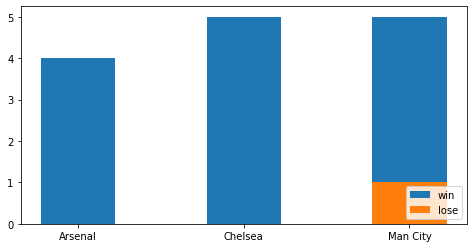

In [15]:
#Dictionaries containing the name of the team as key and the name of referee and the number of games 
#that was present most games as value as a tuple
Dict_1819={}
teams_1819 = sorted(df_prem_1819['HomeTeam'].unique())
for team in teams_1819:
    name = df_prem_1819[(df_prem_1819["HomeTeam"]==team) | (df_prem_1819["AwayTeam"]==team)]['Referee'].value_counts().index[0]
    number = df_prem_1819[(df_prem_1819["HomeTeam"]==team) | (df_prem_1819["AwayTeam"]==team)]['Referee'].value_counts().values[0]
    Dict_1819[team] = (name, number)
#for item in Dict_1819.items():
#    print(item)

    
Dict_1819_WLDRatios={}    
for key in Dict_1819:
    winhome = len(df_prem_1819[(df_prem_1819["HomeTeam"]==key) & (df_prem_1819["Referee"]==Dict_1819[key][0]) & (df_prem_1819["FTR"]=='H')].index)
    winaway = len(df_prem_1819[(df_prem_1819["AwayTeam"]==key) & (df_prem_1819["Referee"]==Dict_1819[key][0]) & (df_prem_1819["FTR"]=='A')].index)
    win = winhome + winaway
    losehome = len(df_prem_1819[(df_prem_1819["HomeTeam"]==key) & (df_prem_1819["Referee"]==Dict_1819[key][0]) & (df_prem_1819["FTR"]=='A')].index)
    loseaway = len(df_prem_1819[(df_prem_1819["AwayTeam"]==key) & (df_prem_1819["Referee"]==Dict_1819[key][0]) & (df_prem_1819["FTR"]=='H')].index)
    lose = losehome + loseaway
    drawhome = len(df_prem_1819[(df_prem_1819["HomeTeam"]==key) & (df_prem_1819["Referee"]==Dict_1819[key][0]) & (df_prem_1819["FTR"]=='D')].index)
    drawaway = len(df_prem_1819[(df_prem_1819["AwayTeam"]==key) & (df_prem_1819["Referee"]==Dict_1819[key][0]) & (df_prem_1819["FTR"]=='D')].index)
    draw = drawhome + drawaway
    Dict_1819_WLDRatios[key] = [win,lose,draw]
    
#for item in Dict_1819_WLDRatios.items():
#    print(item)

t_type = ['Arsenal', 'Chelsea','Man City']
w = [4,5,4]
l = [0,0,1]

ind = [x for x, _ in enumerate(t_type)]
plt.figure(figsize=(8,4))
plt.xticks(range(0,3),t_type)
plt.bar(ind, w, width=0.45, label='win',bottom=l)
plt.bar(ind, l, width=0.45, label='lose')

plt.legend(loc='lower right')
hide_toggle()

<br><br><br><br><br><br>
## 2. Chapter: Crowd attendance

In this chapter we are looking at how the fans in the stadium can influence football games. We are going to compare the last 3 seasons of the premier league. Since not a lot of football fans where allowed inside the stadium in the 2020-2021 season, this is going to offer a great comparison to the other seasons. We are not going to look at the attendance for each individual game but at the average match attendance of each stadium. First lets have a look at the average attendace of each team for every season.

### 2.1 Wins
Up next, we are going to analyse the average attendace of each team for every season. Afterwards we want to look at how many home wins and how many away wins each team got. Afterwards we are going to sum it all together.<br><br><br>

<ipython-input-16-bb3a846e1ab2>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes_4.set_xticklabels(teams_20_21,rotation=90)


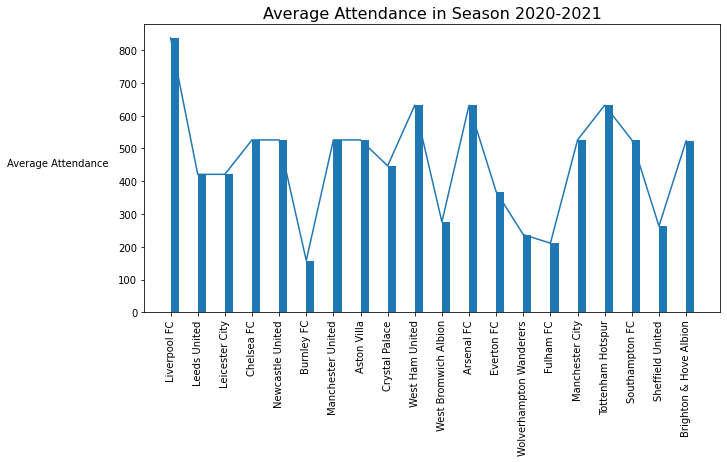

In [16]:
#teams_20_21
#teams_19_20
#teams_18_19
Data_18_19_Avg = Data_18_19
Data_19_20_Avg = Data_19_20
Data_20_21_Avg = Data_20_21

fig1 = plt.figure(figsize=(8,4))
axes_4 = fig1.add_axes([0,0,1,1])
axes_4.set_xticklabels(teams_20_21,rotation=90)
axes_4.set_title('Average Attendance in Season 2020-2021',fontsize=16)
axes_4.set_ylabel('Average Attendance',rotation=0, labelpad=35)
axes_4.yaxis.set_label_coords(-0.15,0.5)
axes_4.plot(teams_20_21, Data_20_21_Avg)

plt.bar(teams_20_21, Data_20_21_Avg, align='edge', width=0.3)
hide_toggle()

<br><br><br>
Now lets have a look at the away wins versus the home wins for each team and try to see if there is an advantage.
<br><br><br>

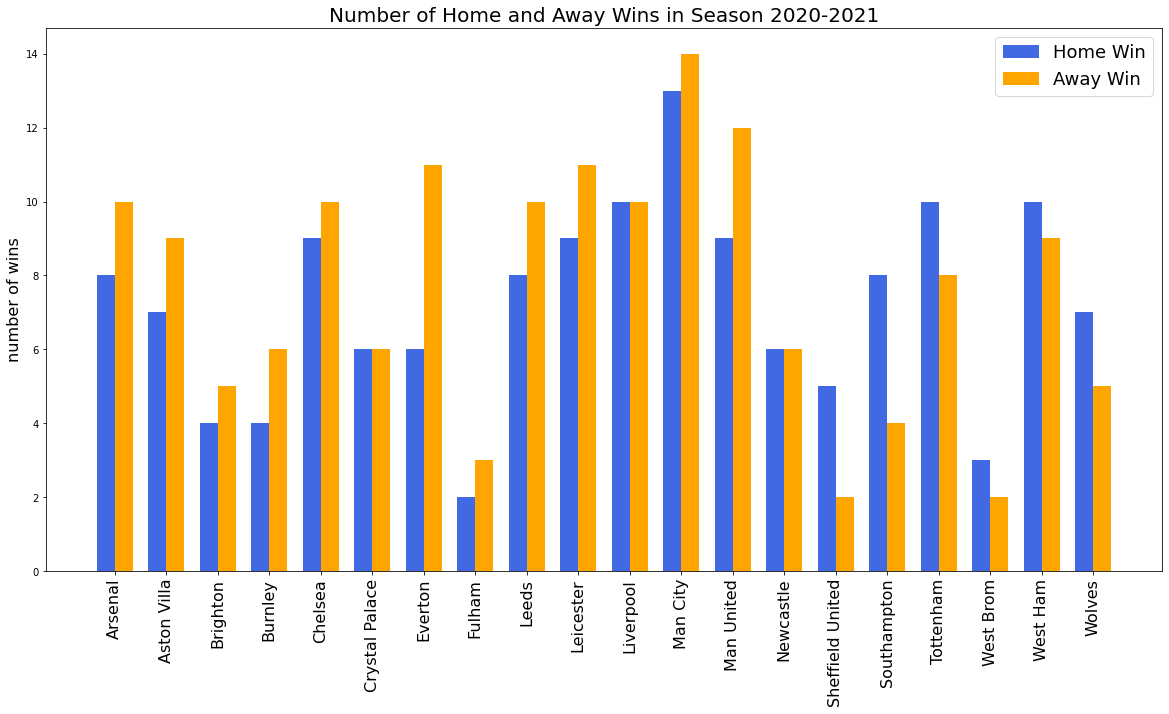

In [17]:
#Dictionaries containing the name of the team as key and the number of wins home and the number of wins away as a tuple
Dict_WinsHomeAway_2021={}
teams_2021 = sorted(df_prem_2021['HomeTeam'].unique())
for team in teams_2021:
    home = len(df_prem_2021[(df_prem_2021["HomeTeam"]==team) & (df_prem_2021["FTR"]=='H')].index)
    away = len(df_prem_2021[(df_prem_2021["AwayTeam"]==team) & (df_prem_2021["FTR"]=='A')].index)
    Dict_WinsHomeAway_2021[team] = (home, away)
#for item in Dict_1819.items():
#    print(item)

t_type = teams_2021
wh=[]
wa=[]
for team in teams_2021:
    wh.append(Dict_WinsHomeAway_2021[team][0])
    wa.append(Dict_WinsHomeAway_2021[team][1])

ind = np.arange(len(teams_2021))
width = 0.35

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, wh, width, color='royalblue')
rects2 = ax.bar(ind+width,wa, width, color='orange')

ax.set_ylabel('number of wins', fontsize=16)
ax.set_title('Number of Home and Away Wins in Season 2020-2021', fontsize=20)
ax.set_xticks(ind+width/2)
ax.set_xticklabels(teams_2021, rotation=90, fontsize=16)

ax.legend((rects1[0],rects2[0]),('Home Win','Away Win'), fontsize=18)

plt.show
hide_toggle()

<br><br><br><br><br><br>
For the season 2019-2020 the data looks the following:

<ipython-input-18-af853f39b8a6>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes_4.set_xticklabels(teams_19_20,rotation=90)


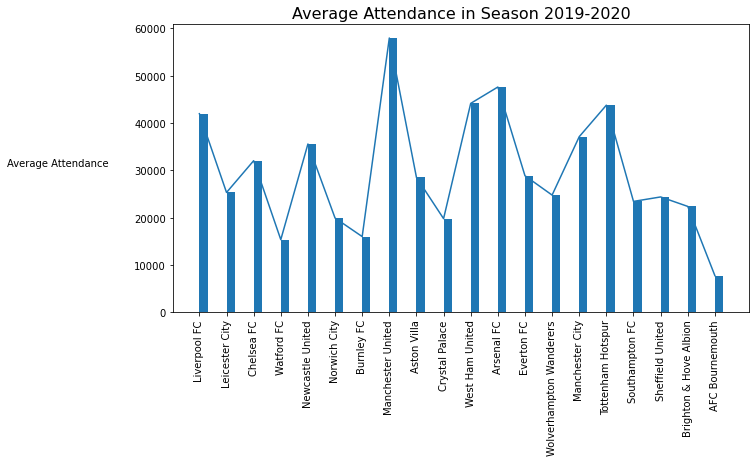

In [18]:
fig1 = plt.figure(figsize=(8,4))
axes_4 = fig1.add_axes([0,0,1,1])
axes_4.set_xticklabels(teams_19_20,rotation=90)
axes_4.set_title('Average Attendance in Season 2019-2020',fontsize=16)
axes_4.set_ylabel('Average Attendance',rotation=0, labelpad=35)
axes_4.yaxis.set_label_coords(-0.2,0.5)
axes_4.plot(teams_19_20, Data_19_20_Avg)

plt.bar(teams_19_20, Data_19_20_Avg, align='edge', width=0.3)
hide_toggle()

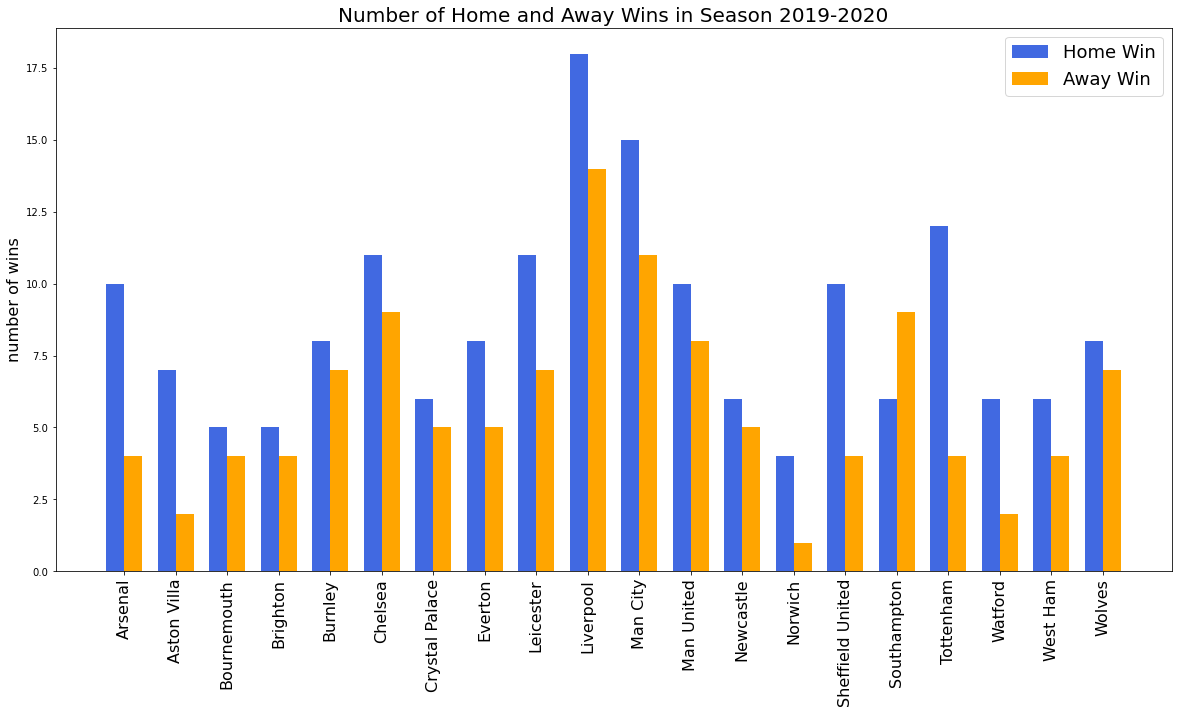

In [19]:
#Dictionaries containing the name of the team as key and the number of wins home and the number of wins away as a tuple
Dict_WinsHomeAway_1920={}
teams_1920 = sorted(df_prem_1920['HomeTeam'].unique())
for team in teams_1920:
    home = len(df_prem_1920[(df_prem_1920["HomeTeam"]==team) & (df_prem_1920["FTR"]=='H')].index)
    away = len(df_prem_1920[(df_prem_1920["AwayTeam"]==team) & (df_prem_1920["FTR"]=='A')].index)
    Dict_WinsHomeAway_1920[team] = (home, away)
#for item in Dict_1819.items():
#    print(item)

t_type = teams_1920
wh=[]
wa=[]
for team in teams_1920:
    wh.append(Dict_WinsHomeAway_1920[team][0])
    wa.append(Dict_WinsHomeAway_1920[team][1])

ind = np.arange(len(teams_1920))
width = 0.35

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, wh, width, color='royalblue')
rects2 = ax.bar(ind+width,wa, width, color='orange')

ax.set_ylabel('number of wins', fontsize=16)
ax.set_title('Number of Home and Away Wins in Season 2019-2020', fontsize=20)
ax.set_xticks(ind+width/2)
ax.set_xticklabels(teams_1920, rotation=90, fontsize=16)

ax.legend((rects1[0],rects2[0]),('Home Win','Away Win'), fontsize=18)

plt.show
hide_toggle()

<br><br><br><br><br><br>
For the season 2018-2019 the data looks the following:

<ipython-input-20-224e0675989e>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes_4.set_xticklabels(teams_18_19,rotation=90)


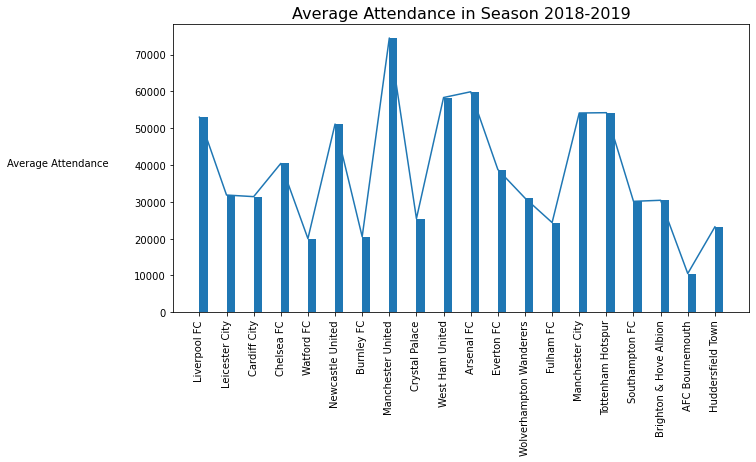

In [20]:
fig1 = plt.figure(figsize=(8,4))
axes_4 = fig1.add_axes([0,0,1,1])
axes_4.set_xticklabels(teams_18_19,rotation=90)
axes_4.set_title('Average Attendance in Season 2018-2019',fontsize=16)
axes_4.set_ylabel('Average Attendance',rotation=0, labelpad=35)
axes_4.yaxis.set_label_coords(-0.2,0.5)
axes_4.plot(teams_18_19, Data_18_19_Avg)

plt.bar(teams_18_19, Data_18_19_Avg, align='edge', width=0.3)
hide_toggle()

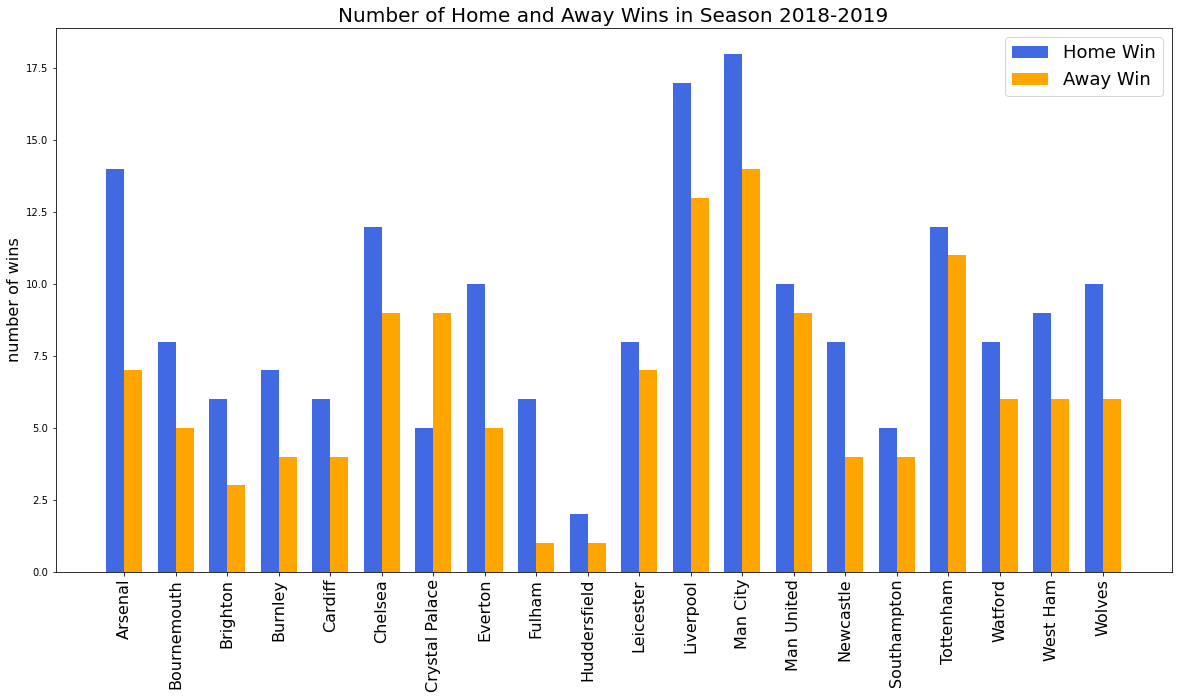

In [21]:
#Dictionaries containing the name of the team as key and the number of wins home and the number of wins away as a tuple
Dict_WinsHomeAway_1819={}
teams_1819 = sorted(df_prem_1819['HomeTeam'].unique())
for team in teams_1819:
    home = len(df_prem_1819[(df_prem_1819["HomeTeam"]==team) & (df_prem_1819["FTR"]=='H')].index)
    away = len(df_prem_1819[(df_prem_1819["AwayTeam"]==team) & (df_prem_1819["FTR"]=='A')].index)
    Dict_WinsHomeAway_1819[team] = (home, away)
#for item in Dict_1819.items():
#    print(item)

t_type = teams_1819
wh=[]
wa=[]
for team in teams_1819:
    wh.append(Dict_WinsHomeAway_1819[team][0])
    wa.append(Dict_WinsHomeAway_1819[team][1])

ind = np.arange(len(teams_1819))
width = 0.35

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, wh, width, color='royalblue')
rects2 = ax.bar(ind+width,wa, width, color='orange')

ax.set_ylabel('number of wins', fontsize=16)
ax.set_title('Number of Home and Away Wins in Season 2018-2019', fontsize=20)
ax.set_xticks(ind+width/2)
ax.set_xticklabels(teams_1819, rotation=90, fontsize=16)

ax.legend((rects1[0],rects2[0]),('Home Win','Away Win'), fontsize=18)

plt.show
hide_toggle()

<br><br><br><br><br><br>
If we put all this data next to each other, we can clearly see from the charts that in the season 2020-2021, it did not really matter whether a team played at home or away since since there was almost a 50-50 chance of winning. However in the two season before where the number of fans in stadiums was larger we notice that almost 60% of wins came when teams were playing at home.<br>I think it is safe to say that having spectators in the stadium therefore brings a little bit of an advantage for the home team.
<br>
<br>

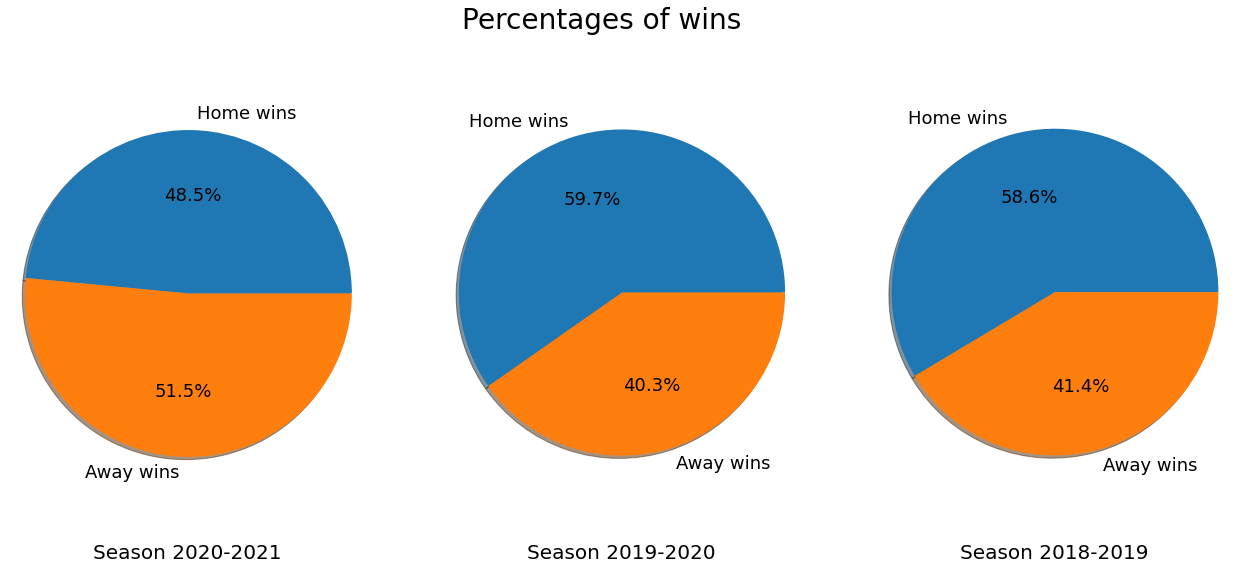

In [22]:
winshome1=0
winsaway1=0
for team in teams_2021:
    winshome1 = winshome1 + Dict_WinsHomeAway_2021[team][0]
    winsaway1 = winsaway1 + Dict_WinsHomeAway_2021[team][1]
sizes1 = [winshome1, winsaway1]
winshome2=0
winsaway2=0
for team in teams_1920:
    winshome2 = winshome2 + Dict_WinsHomeAway_1920[team][0]
    winsaway2 = winsaway2 + Dict_WinsHomeAway_1920[team][1]
sizes2 = [winshome2, winsaway2]
winshome3=0
winsaway3=0
for team in teams_1819:
    winshome3 = winshome3 + Dict_WinsHomeAway_1819[team][0]
    winsaway3 = winsaway3 + Dict_WinsHomeAway_1819[team][1]
sizes3 = [winshome3, winsaway3]

labels = ['Home wins','Away wins']

fig1, ax1 = plt.subplots(1,3)
fig1.set_figheight(10)
fig1.set_figwidth(22)
fig1.subplots_adjust(wspace=0.2)
fig1.suptitle('Percentages of wins', fontsize=28, y= 0.9)
ax1[0].set_title('Season 2020-2021',fontsize=20, y=0)
ax1[1].set_title('Season 2019-2020',fontsize=20, y=0)
ax1[2].set_title('Season 2018-2019',fontsize=20, y=0)

ax1[0].pie(sizes1, labels=labels, autopct='%1.1f%%', radius = 1.2, textprops=dict(fontsize=18),
        shadow=True, startangle=0)
ax1[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%', radius = 1.2, textprops=dict(fontsize=18),
        shadow=True, startangle=0)
ax1[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[2].pie(sizes3, labels=labels, autopct='%1.1f%%', radius = 1.2, textprops=dict(fontsize=18),
        shadow=True, startangle=0)
ax1[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()

hide_toggle()

<br><br><br>
#### 2.2 Yellow cards

Secondly we want to look if the crowd can influence the referee so that he gives more yellow cards to the home team.

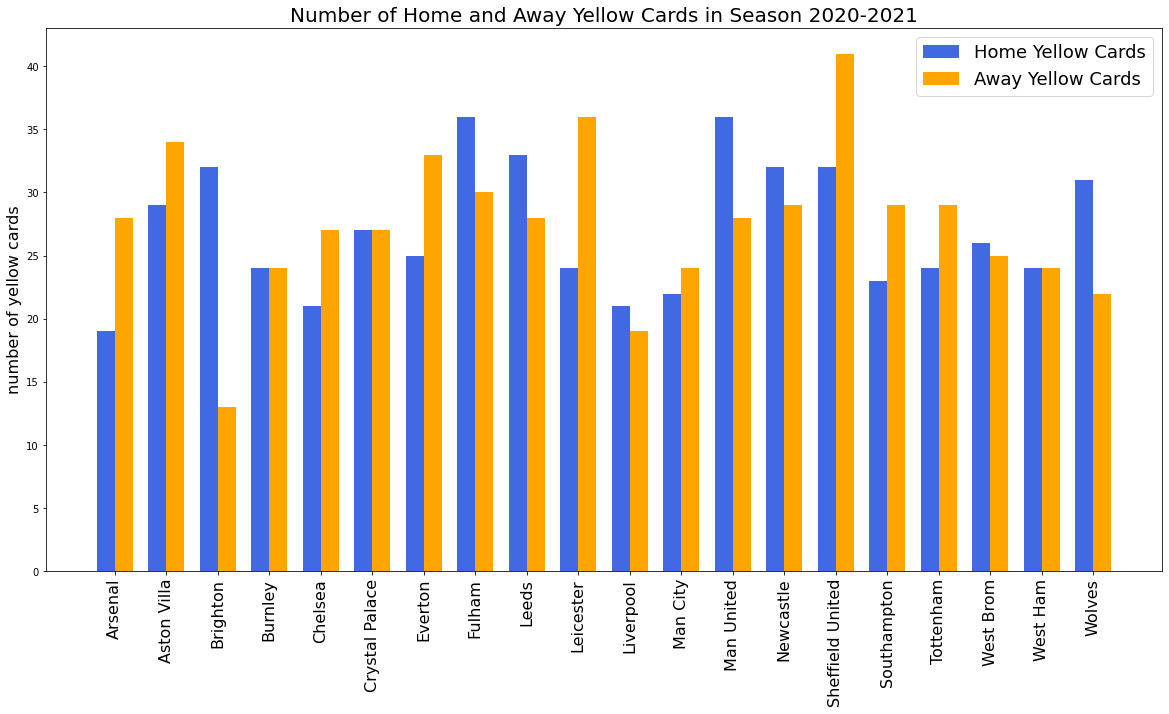

In [23]:
#Dictionaries containing the name of the team as key and the number of yellow cards home and the number of yellow cards away as a tuple
Dict_YellowHomeAway_2021={}
teams_2021 = sorted(df_prem_2021['HomeTeam'].unique())
for team in teams_2021:
    home = sum(df_prem_2021[(df_prem_2021["HomeTeam"]==team)]['HY'])
    away = sum(df_prem_2021[(df_prem_2021["AwayTeam"]==team)]['AY'])
    Dict_YellowHomeAway_2021[team] = (home, away)
#for item in Dict_1819.items():
#    print(item)

t_type = teams_2021
yh=[]
ya=[]
for team in teams_2021:
    yh.append(Dict_YellowHomeAway_2021[team][0])
    ya.append(Dict_YellowHomeAway_2021[team][1])

ind = np.arange(len(teams_2021))
width = 0.35

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, yh, width, color='royalblue')
rects2 = ax.bar(ind+width, ya, width, color='orange')

ax.set_ylabel('number of yellow cards', fontsize=16)
ax.set_title('Number of Home and Away Yellow Cards in Season 2020-2021', fontsize=20)
ax.set_xticks(ind+width/2)
ax.set_xticklabels(teams_2021, rotation=90, fontsize=16)

ax.legend((rects1[0],rects2[0]),('Home Yellow Cards','Away Yellow Cards'), fontsize=18)

plt.show

hide_toggle()

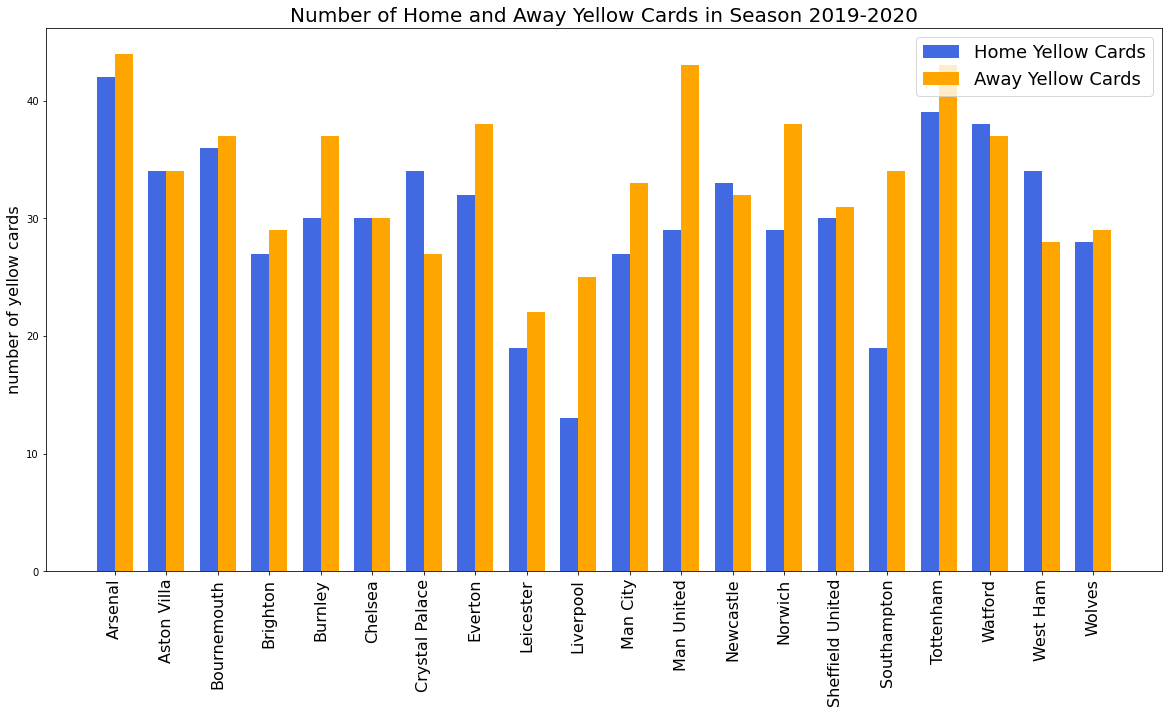

In [24]:
#Dictionaries containing the name of the team as key and the number of yellow cards home and the number of yellow cards away as a tuple
Dict_YellowHomeAway_1920={}
teams_1920 = sorted(df_prem_1920['HomeTeam'].unique())
for team in teams_1920:
    home = sum(df_prem_1920[(df_prem_1920["HomeTeam"]==team)]['HY'])
    away = sum(df_prem_1920[(df_prem_1920["AwayTeam"]==team)]['AY'])
    Dict_YellowHomeAway_1920[team] = (home, away)
#for item in Dict_1819.items():
#    print(item)

t_type = teams_1920
yh=[]
ya=[]
for team in teams_1920:
    yh.append(Dict_YellowHomeAway_1920[team][0])
    ya.append(Dict_YellowHomeAway_1920[team][1])

ind = np.arange(len(teams_1920))
width = 0.35

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, yh, width, color='royalblue')
rects2 = ax.bar(ind+width, ya, width, color='orange')

ax.set_ylabel('number of yellow cards', fontsize=16)
ax.set_title('Number of Home and Away Yellow Cards in Season 2019-2020', fontsize=20)
ax.set_xticks(ind+width/2)
ax.set_xticklabels(teams_1920, rotation=90, fontsize=16)

ax.legend((rects1[0],rects2[0]),('Home Yellow Cards','Away Yellow Cards'), fontsize=18)

plt.show
hide_toggle()

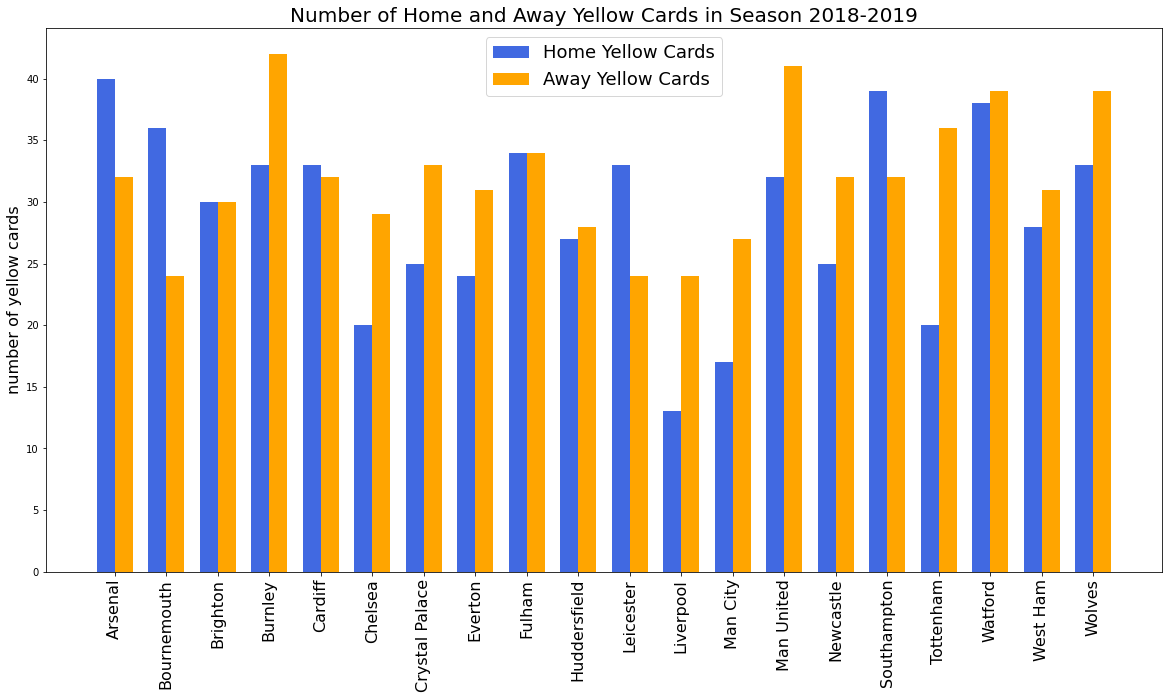

In [25]:
#Dictionaries containing the name of the team as key and the number of yellow cards home and the number of yellow cards away as a tuple
Dict_YellowHomeAway_1819={}
teams_1819 = sorted(df_prem_1819['HomeTeam'].unique())
for team in teams_1819:
    home = sum(df_prem_1819[(df_prem_1819["HomeTeam"]==team)]['HY'])
    away = sum(df_prem_1819[(df_prem_1819["AwayTeam"]==team)]['AY'])
    Dict_YellowHomeAway_1819[team] = (home, away)
#for item in Dict_1819.items():
#    print(item)

t_type = teams_1819
yh=[]
ya=[]
for team in teams_1819:
    yh.append(Dict_YellowHomeAway_1819[team][0])
    ya.append(Dict_YellowHomeAway_1819[team][1])

ind = np.arange(len(teams_1819))
width = 0.35

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, yh, width, color='royalblue')
rects2 = ax.bar(ind+width, ya, width, color='orange')

ax.set_ylabel('number of yellow cards', fontsize=16)
ax.set_title('Number of Home and Away Yellow Cards in Season 2018-2019', fontsize=20)
ax.set_xticks(ind+width/2)
ax.set_xticklabels(teams_1819, rotation=90, fontsize=16)

ax.legend((rects1[0],rects2[0]),('Home Yellow Cards','Away Yellow Cards'), fontsize=18)

plt.show
hide_toggle()

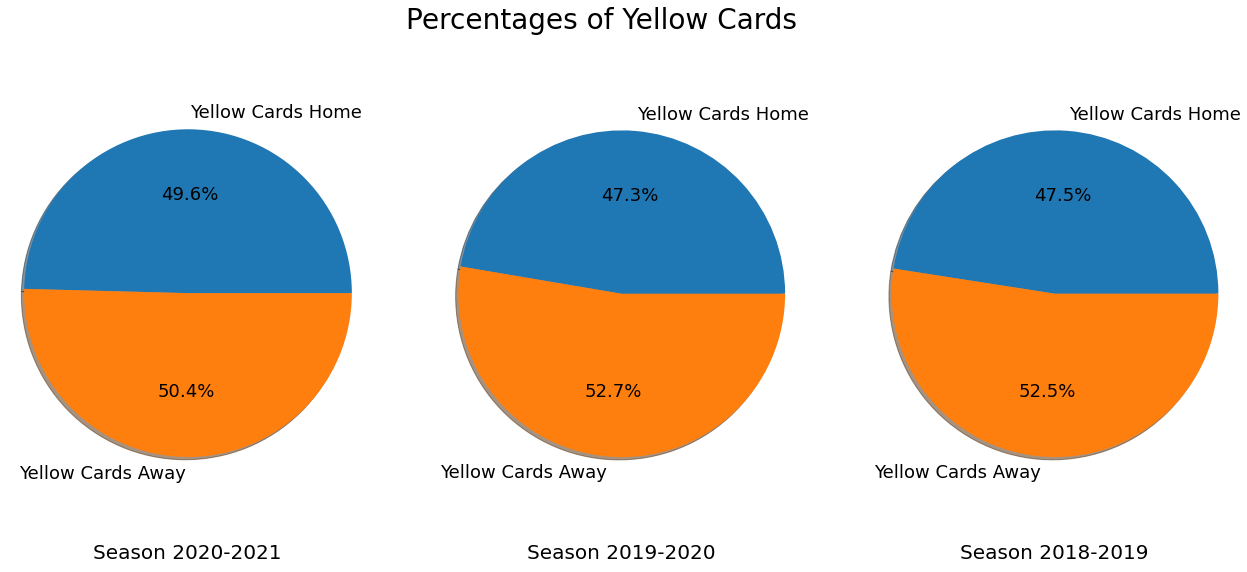

In [26]:
yellowhome1=0
yellowaway1=0
for team in teams_2021:
    yellowhome1 = yellowhome1 + Dict_YellowHomeAway_2021[team][0]
    yellowaway1 = yellowaway1 + Dict_YellowHomeAway_2021[team][1]
sizes1 = [yellowhome1, yellowaway1]
yellowhome2=0
yellowaway2=0
for team in teams_1920:
    yellowhome2 = yellowhome2 + Dict_YellowHomeAway_1920[team][0]
    yellowaway2 = yellowaway2 + Dict_YellowHomeAway_1920[team][1]
sizes2 = [yellowhome2, yellowaway2]
yellowhome3=0
yellowaway3=0
for team in teams_1819:
    yellowhome3 = yellowhome3 + Dict_YellowHomeAway_1819[team][0]
    yellowaway3 = yellowaway3 + Dict_YellowHomeAway_1819[team][1]
sizes3 = [yellowhome3, yellowaway3]

labels = ['Yellow Cards Home','Yellow Cards Away']

fig1, ax1 = plt.subplots(1,3)
fig1.set_figheight(10)
fig1.set_figwidth(22)
fig1.subplots_adjust(wspace=0.2)
fig1.suptitle('Percentages of Yellow Cards', fontsize=28, y= 0.9)
ax1[0].set_title('Season 2020-2021',fontsize=20, y=0)
ax1[1].set_title('Season 2019-2020',fontsize=20, y=0)
ax1[2].set_title('Season 2018-2019',fontsize=20, y=0)

ax1[0].pie(sizes1, labels=labels, autopct='%1.1f%%', radius = 1.2, textprops=dict(fontsize=18),
        shadow=True, startangle=0)
ax1[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%', radius = 1.2, textprops=dict(fontsize=18),
        shadow=True, startangle=0)
ax1[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1[2].pie(sizes3, labels=labels, autopct='%1.1f%%', radius = 1.2, textprops=dict(fontsize=18),
        shadow=True, startangle=0)
ax1[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()

hide_toggle()

In the case of the yellow cards the trend is not that obvious, although that without the crowd present, the distribution seems to be more along the 50-50. In the other two seasons the referee is inclined to give slightly more yellow cards to the away team, when the fans were present in the stadium.

<br><br><br><br><br><br>
## 3. Chapter: Time of the year

In this chapter we are going to analyse different statistics of football games based on the time of the year.

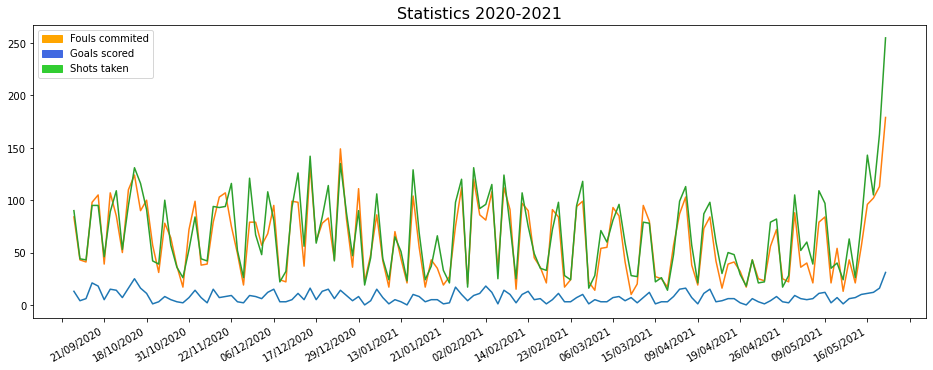

In [27]:
dates = []

for i in df_prem_2021['Date'].value_counts().index:
    dates.append(i)
    
newDates = [datetime.datetime.strptime(ts, "%d/%m/%Y") for ts in dates]
newDates.sort()
sortedDates = [datetime.datetime.strftime(ts, "%d/%m/%Y") for ts in newDates]
#sortedDates

Dict_goals_date = {}

#df_prem_2021[df_prem_2021['Date'] == '12/09/2020']['FTHG'].values
for date in sortedDates:
    sumGoals = 0
    for goals in df_prem_2021[df_prem_2021['Date'] == date]['FTHG'].values:
        sumGoals += goals
    for goals in df_prem_2021[df_prem_2021['Date'] == date]['FTAG'].values:
        sumGoals += goals
    Dict_goals_date[date] = sumGoals
    
Dict_fouls_date = {}

for date in sortedDates:
    sumFouls = 0
    for fouls in df_prem_2021[df_prem_2021['Date'] == date]['HF'].values:
        sumFouls += fouls
    for fouls in df_prem_2021[df_prem_2021['Date'] == date]['AF'].values:
        sumFouls += fouls
    Dict_fouls_date[date] = sumFouls
    
Dict_shots_date = {}

for date in sortedDates:
    sumShots = 0
    for shots in df_prem_2021[df_prem_2021['Date'] == date]['HS'].values:
        sumShots += shots
    for shots in df_prem_2021[df_prem_2021['Date'] == date]['AS'].values:
        sumShots += shots
    Dict_shots_date[date] = sumShots

    
#Dict_goals_date.keys()
#Dict_goals_date.values()
fig, ax = plt.subplots(figsize=(16,6))
weekly_locator = mdates.WeekdayLocator(interval=1)

ax.xaxis.set_major_locator(weekly_locator)
ax.set_title("Statistics 2020-2021", fontsize=16)

ax.plot(Dict_goals_date.keys(), Dict_goals_date.values(), Dict_fouls_date.keys(), Dict_fouls_date.values(), Dict_shots_date.keys(), Dict_shots_date.values())

orange_patch = mpatches.Patch(color='orange', label='Fouls commited')
blue_patch = mpatches.Patch(color='royalblue', label='Goals scored')
green_patch = mpatches.Patch(color='limegreen', label='Shots taken')
plt.legend(handles=[orange_patch, blue_patch, green_patch])
#plt.legend('Goals scored', 'Fouls commited')
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)

fig.autofmt_xdate()

hide_toggle()

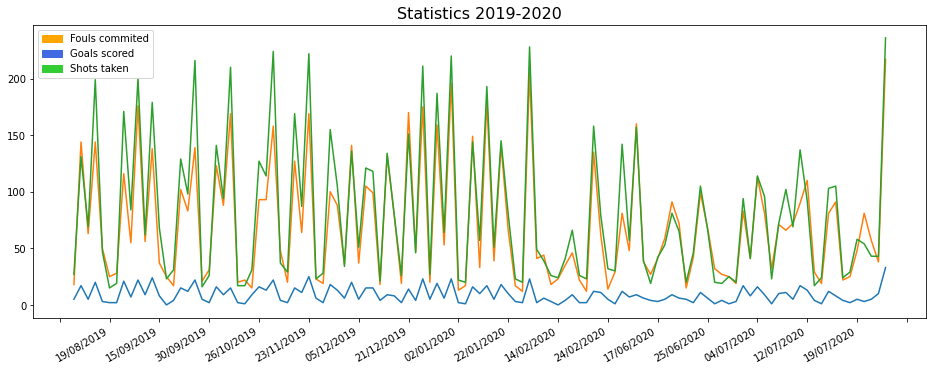

In [28]:
dates = []

for i in df_prem_1920['Date'].value_counts().index:
    dates.append(i)
    
newDates = [datetime.datetime.strptime(ts, "%d/%m/%Y") for ts in dates]
newDates.sort()
sortedDates = [datetime.datetime.strftime(ts, "%d/%m/%Y") for ts in newDates]
#sortedDates

Dict_goals_date = {}

#df_prem_2021[df_prem_2021['Date'] == '12/09/2020']['FTHG'].values
for date in sortedDates:
    sumGoals = 0
    for goals in df_prem_1920[df_prem_1920['Date'] == date]['FTHG'].values:
        sumGoals += goals
    for goals in df_prem_1920[df_prem_1920['Date'] == date]['FTAG'].values:
        sumGoals += goals
    Dict_goals_date[date] = sumGoals
    
Dict_fouls_date = {}

for date in sortedDates:
    sumFouls = 0
    for fouls in df_prem_1920[df_prem_1920['Date'] == date]['HF'].values:
        sumFouls += fouls
    for fouls in df_prem_1920[df_prem_1920['Date'] == date]['AF'].values:
        sumFouls += fouls
    Dict_fouls_date[date] = sumFouls
    
Dict_shots_date = {}

for date in sortedDates:
    sumShots = 0
    for shots in df_prem_1920[df_prem_1920['Date'] == date]['HS'].values:
        sumShots += shots
    for shots in df_prem_1920[df_prem_1920['Date'] == date]['AS'].values:
        sumShots += shots
    Dict_shots_date[date] = sumShots

    
#Dict_goals_date.keys()
#Dict_goals_date.values()
fig, ax = plt.subplots(figsize=(16,6))
weekly_locator = mdates.WeekdayLocator(interval=1)

ax.xaxis.set_major_locator(weekly_locator)
ax.set_title("Statistics 2019-2020", fontsize=16)

ax.plot(Dict_goals_date.keys(), Dict_goals_date.values(), Dict_fouls_date.keys(), Dict_fouls_date.values(), Dict_shots_date.keys(), Dict_shots_date.values())

orange_patch = mpatches.Patch(color='orange', label='Fouls commited')
blue_patch = mpatches.Patch(color='royalblue', label='Goals scored')
green_patch = mpatches.Patch(color='limegreen', label='Shots taken')
plt.legend(handles=[orange_patch, blue_patch, green_patch])
#plt.legend('Goals scored', 'Fouls commited')
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)

fig.autofmt_xdate()

hide_toggle()

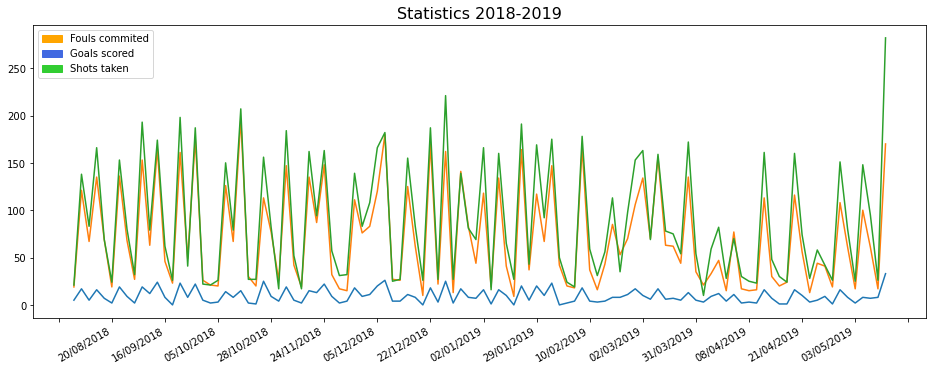

In [31]:
dates = []

for i in df_prem_1819['Date'].value_counts().index:
    dates.append(i)
    
newDates = [datetime.datetime.strptime(ts, "%d/%m/%Y") for ts in dates]
newDates.sort()
sortedDates = [datetime.datetime.strftime(ts, "%d/%m/%Y") for ts in newDates]
#sortedDates

Dict_goals_date = {}

#df_prem_2021[df_prem_2021['Date'] == '12/09/2020']['FTHG'].values
for date in sortedDates:
    sumGoals = 0
    for goals in df_prem_1920[df_prem_1819['Date'] == date]['FTHG'].values:
        sumGoals += goals
    for goals in df_prem_1920[df_prem_1819['Date'] == date]['FTAG'].values:
        sumGoals += goals
    Dict_goals_date[date] = sumGoals
    
Dict_fouls_date = {}

for date in sortedDates:
    sumFouls = 0
    for fouls in df_prem_1819[df_prem_1819['Date'] == date]['HF'].values:
        sumFouls += fouls
    for fouls in df_prem_1819[df_prem_1819['Date'] == date]['AF'].values:
        sumFouls += fouls
    Dict_fouls_date[date] = sumFouls
    
Dict_shots_date = {}

for date in sortedDates:
    sumShots = 0
    for shots in df_prem_1819[df_prem_1819['Date'] == date]['HS'].values:
        sumShots += shots
    for shots in df_prem_1819[df_prem_1819['Date'] == date]['AS'].values:
        sumShots += shots
    Dict_shots_date[date] = sumShots

    
#Dict_goals_date.keys()
#Dict_goals_date.values()
fig, ax = plt.subplots(figsize=(16,6))
weekly_locator = mdates.WeekdayLocator(interval=1)

ax.xaxis.set_major_locator(weekly_locator)
ax.set_title("Statistics 2018-2019", fontsize=16)

ax.plot(Dict_goals_date.keys(), Dict_goals_date.values(), Dict_fouls_date.keys(), Dict_fouls_date.values(), Dict_shots_date.keys(), Dict_shots_date.values())

orange_patch = mpatches.Patch(color='orange', label='Fouls commited')
blue_patch = mpatches.Patch(color='royalblue', label='Goals scored')
green_patch = mpatches.Patch(color='limegreen', label='Shots taken')
plt.legend(handles=[orange_patch, blue_patch, green_patch])
#plt.legend('Goals scored', 'Fouls commited')
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)

fig.autofmt_xdate()

hide_toggle()